In [1]:
from tensorflow.keras.models import Model # Импортируем модели keras: Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization, Flatten, Dense, Dropout, Conv2DTranspose, Concatenate, Reshape
from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from tensorflow.keras import callbacks
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
from google.colab import files # Импортируем Модуль files для работы с файлами
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from tensorflow.keras.preprocessing import image # Импортируем модуль image для работы с изображениями
import numpy as np # Импортируем библиотеку numpy
from sklearn.model_selection import train_test_split
import time
import random
import math
import os # Импортируем библиотеку os для раоты с фаловой системой
from PIL import Image # импортируем модель Image для работы с изображениями
from google.colab import drive
import datetime

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset_zip   = '/content/drive/MyDrive/Colab\ Notebooks/Machine_learning/Control_points/CP3/food-09.zip' # Файл с датасетом машин
dataset = '/content/food-09'

In [4]:
!rm -rf {dataset}

In [5]:
!unzip -q {dataset_zip} -d {dataset}

In [6]:
# словарь с таблицами вероятностей (верными ответами)
labels = {}
labels['foie_gras'] = [1,0,0]
labels['gyoza'] = [0,1,0]
labels['lasagna'] = [0,0,1]

# список для удобного обращения к названию по индексу
labels_list = ["foie_gras", "gyoza", "lasagna"]

In [7]:
def smart_trimming(img):
  img_w, img_h = img.size   # Берём размер картинки
  target_size = [120, 120]  # Размер, который мы должны получить в результате

  # Проверка на формат
  if img_w > img_h:
    new_h = target_size[1]                # Высота - основная ось
    new_w = round(new_h / img_h * img_w)  # Вычисление ширины
  else:
    new_w = target_size[0]                # Ширина - основная ось
    new_h = round(new_w / img_w * img_h)  # Вычисление высоты

  # Изменения касательно размеров
  img = img.resize((new_w, new_h), Image.ANTIALIAS)

  # Поиск центра картинки
  center = [new_w//2, new_h//2]

  # Поиск координат для прямоугольной обрезки
  top_left = [center[0] - target_size[0]//2, center[1] - target_size[1]//2]
  bottom_right = [center[0] + target_size[0]//2, center[1] + target_size[1]//2]

  # Обрезка изображения
  img = img.crop((top_left[0], top_left[1], bottom_right[0], bottom_right[1]))

  return img

In [8]:
# списки с путями к картинкам

image_list = []
test_image_list = []

# проходимся по папкам с изображениями
for label in labels.keys():
  dir = dataset +"/" + label
  flist = os.listdir(dataset + "/" + label)
  test_count = 0
  for f in flist:
    # Заполнение списка для тестовой выборки
    if test_count < 2:
      fpath = dataset+ "/" + label + "/" + f
      test_image_list.append(fpath)
      
      test_count += 1
      continue

    # Заполнение списка для остальных выборок
    fpath = dataset+ "/" + label + "/" + f
    image_list.append(fpath)

# перемешиваем оба списка, чтобы в н.с. изображения попадали в случайном порядке.
random.shuffle(image_list)
random.shuffle(test_image_list)

In [9]:
# Формирование массивов выборок, как обычных массивов.
x_train = []
y_train = []

x_test = []
y_test = []

In [10]:
# Заполнение тестовых выборок
for fpath in test_image_list:
  img = Image.open(fpath)
  img = smart_trimming(img) # Приведение к единому формату

  img = np.array(img)

  # Проверка, на случай, если функция умной обрезки несработала и не выдала ошибку
  if img.shape == (120, 120, 3):
    x_test.append(img)

    label = fpath.split('/')[3] # Получение верного ответа из пути
    y_test.append(labels[label])

In [11]:
# Заполнение обучающей выборки
for fpath in image_list:
  img = Image.open(fpath)
  img = smart_trimming(img) # Приведение к единому формату

  img = np.array(img)

  # Проверка, на случай, если функция умной обрезки несработала и не выдала ошибку
  if img.shape == (120, 120, 3):
    x_train.append(img)

    label = fpath.split('/')[3] # Получение верного ответа из пути
    y_train.append(labels[label])

In [12]:
# проверка размеров списков
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

2993 2993
6 6


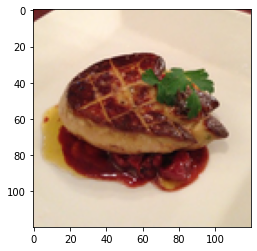

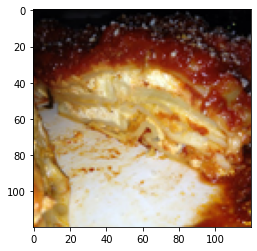

In [13]:
# проверка картинок в списках
plt.imshow(x_train[67])
plt.show()

plt.imshow(x_test[0])
plt.show()

In [29]:
# "превращаем" списки в np.array #TODO: проблема!
x_train = np.array(x_train)
y_train = np.array(y_train)

# формируем проверочную выборку

# При указании числа опираемся на то, сколько изображений от обучающей выборки следует взять
x_val = x_train[2500:]
y_val = y_train[2500:]

# Исключаем изображения взятые для проверочной выборки из обучающей.
x_train = x_train[:2500]
y_train = y_train[:2500]

# "превращаем" списки в np.array
x_test = np.array(x_test)
y_test = np.array(y_test)

# проверяем размер x_val
# print(x_val.shape)

In [16]:
# модель функциональной нейронной сети

batch_size = 16

img_input = Input((120, 120, 3))

# первая ветка

x = BatchNormalization()(img_input)
x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D()(x)
x = Dropout(0.3)(x)

x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D()(x)
x = Dropout(0.3)(x)

# вторая ветка

y = BatchNormalization()(img_input)
y = Conv2D(32, (2, 2), padding='same', activation='relu')(y)
y = MaxPooling2D()(y)
y = Dropout(0.3)(y)

y = BatchNormalization()(y)
y = Conv2D(64, (2, 2), padding='same', activation='relu')(y)
y = MaxPooling2D()(y)
y = Dropout(0.3)(y)

# соединяем ветки
a = concatenate([x,y])

a = BatchNormalization()(a)
a = Conv2D(128, (3, 3), padding='same', activation='relu')(a)
a = MaxPooling2D()(a)
a = Dropout(0.3)(a)

a = BatchNormalization()(a)
a = Flatten()(a)
a = Dense(3, activation='softmax')(a)

model_func = Model(img_input, a)

In [17]:
# описание модели
model_func.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 120, 120, 3)  12         ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 120, 120, 3)  12         ['input_1[0][0]']                
 rmalization)                                                                                 

Epoch 1/10
157/157 [==============================] - 12s 17ms/step - loss: 15.2601 - accuracy: 0.4740 - val_loss: 22.2524 - val_accuracy: 0.3874
Epoch 2/10
157/157 [==============================] - 2s 14ms/step - loss: 2.7799 - accuracy: 0.5472 - val_loss: 1.0593 - val_accuracy: 0.5477
Epoch 3/10
157/157 [==============================] - 2s 14ms/step - loss: 0.8865 - accuracy: 0.6212 - val_loss: 0.9599 - val_accuracy: 0.6126
Epoch 4/10
157/157 [==============================] - 2s 14ms/step - loss: 0.8394 - accuracy: 0.6360 - val_loss: 0.8537 - val_accuracy: 0.6065
Epoch 5/10
157/157 [==============================] - 2s 14ms/step - loss: 0.7968 - accuracy: 0.6620 - val_loss: 0.8792 - val_accuracy: 0.6045
Epoch 6/10
157/157 [==============================] - 2s 14ms/step - loss: 0.8063 - accuracy: 0.6588 - val_loss: 0.8295 - val_accuracy: 0.6369
Epoch 7/10
157/157 [==============================] - 2s 14ms/step - loss: 0.7701 - accuracy: 0.6776 - val_loss: 0.9805 - val_accuracy: 0.6

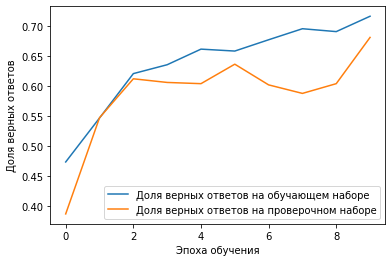

In [18]:
model_func.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

# Обучаем сеть на наших данных
history = model_func.fit(x_train, 
                    y_train, 
                    batch_size=batch_size, 
                    epochs=10,
                    validation_data=(x_val, y_val),
                    verbose=1)

# Отображение графика
plt.plot(history.history['accuracy'], label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

Epoch 1/10
157/157 [==============================] - 3s 16ms/step - loss: 0.5216 - accuracy: 0.7864 - val_loss: 0.8430 - val_accuracy: 0.6572
Epoch 2/10
157/157 [==============================] - 2s 14ms/step - loss: 0.4798 - accuracy: 0.7968 - val_loss: 0.8869 - val_accuracy: 0.6004
Epoch 3/10
157/157 [==============================] - 2s 14ms/step - loss: 0.4208 - accuracy: 0.8296 - val_loss: 0.7906 - val_accuracy: 0.6775
Epoch 4/10
157/157 [==============================] - 2s 14ms/step - loss: 0.4059 - accuracy: 0.8388 - val_loss: 0.7904 - val_accuracy: 0.6613
Epoch 5/10
157/157 [==============================] - 2s 14ms/step - loss: 0.3521 - accuracy: 0.8608 - val_loss: 0.8659 - val_accuracy: 0.6592
Epoch 6/10
157/157 [==============================] - 2s 14ms/step - loss: 0.3454 - accuracy: 0.8616 - val_loss: 0.7879 - val_accuracy: 0.6613
Epoch 7/10
157/157 [==============================] - 2s 14ms/step - loss: 0.2961 - accuracy: 0.8832 - val_loss: 0.9006 - val_accuracy: 0.6430

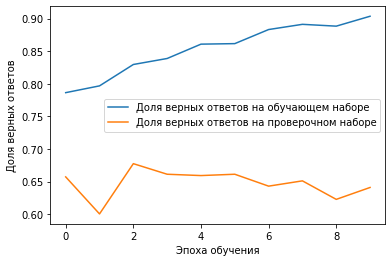

In [19]:
model_func.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

# Обучаем сеть на наших данных
history = model_func.fit(x_train, 
                    y_train, 
                    batch_size=batch_size, 
                    epochs=10,
                    validation_data=(x_val, y_val),
                    verbose=1)

# Отображение графика
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

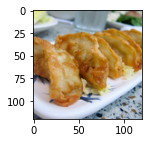

Выход сети:
[0.01037778 0.5967055  0.39291674]

0 -> 0.0103777796030044555664062500000000000000
1 -> 0.5967054963111877441406250000000000000000
2 -> 0.3929167389869689941406250000000000000000

Распознан объект:  1 - gyoza
Верный ответ:  1 - gyoza


In [30]:
prediction = model_func.predict(x_test)

n = 5

img = x_test[n]
img = img.reshape(120, 120, 3)
img = img.astype('uint8')
plt.figure(figsize=(2, 2))
plt.imshow(Image.fromarray(img)) #Отображаем изображение i-ым графиков
plt.show()

print("Выход сети:")
print(prediction[n])
print()
for i in range(3):
  print(i,"->","{:.40f}".format(prediction[n][i]))
print()
# print(labels[np.argmax(prediction[n])])
print("Распознан объект: ", np.argmax(prediction[n]), "-", labels_list[np.argmax(prediction[n])])
print("Верный ответ: ", np.argmax(y_test[n]), "-", labels_list[np.argmax(y_test[n])])